In [1]:
#initializing packages needed to clean data
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

In [2]:
#appending all 27 weeks of csv data together to be read
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [
181013,181020,181027,
181103,181110,181117,181124,
181201,181208,181215,181222,181229,         
190105,190112,190119,190126,
190202,190209,190216,190223,
190302,190309,190316,190323,190330,
190406,190413]
turnstiles_df = get_data(week_nums)

In [3]:
#stripping extra spaces in the name of "EXITS" so referencing it isnt difficult
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [4]:
#making a new column DATE_TIME by reading the the date and time in their format as input in the mta data table
import datetime
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [5]:
#checking for and droping duplicate rows (audit recovers and regular entries)
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [6]:
#selecting the first cumulative entry of ENTRIES for every date
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2019,6892430
1,A002,R051,02-00-00,59 ST,01/02/2019,6893894
2,A002,R051,02-00-00,59 ST,01/03/2019,6895434
3,A002,R051,02-00-00,59 ST,01/04/2019,6896974
4,A002,R051,02-00-00,59 ST,01/05/2019,6897740
...,...,...,...,...,...,...
902541,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/27/2018,5554
902542,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/28/2018,5554
902543,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/29/2018,5554
902544,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/30/2018,5554


In [7]:
#creating new columns PREV_DATE and PREV_ENTRIES that are shifted down one row (copies of DATE and ENYRIES columns)
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))
turnstiles_daily 

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2019,6892430,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/02/2019,6893894,01/01/2019,6892430.0
2,A002,R051,02-00-00,59 ST,01/03/2019,6895434,01/02/2019,6893894.0
3,A002,R051,02-00-00,59 ST,01/04/2019,6896974,01/03/2019,6895434.0
4,A002,R051,02-00-00,59 ST,01/05/2019,6897740,01/04/2019,6896974.0
...,...,...,...,...,...,...,...,...
902541,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/27/2018,5554,12/26/2018,5554.0
902542,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/28/2018,5554,12/27/2018,5554.0
902543,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/29/2018,5554,12/28/2018,5554.0
902544,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/30/2018,5554,12/29/2018,5554.0


In [8]:
#dropping null values in PREV_DATE
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [9]:
#implementing function to get rid of negative values for counter and also get rid of outliers
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 7653517 <-- 153545.0
entries: 416 <-- 7705439.0
entries: 15217602 <-- 323270.0
entries: 2170 <-- 15256718.0
entries: 885868970 <-- 128942.0
entries: 120 <-- 885834996.0
entries: 16737744 <-- 178223.0
entries: 197 <-- 16816011.0
entries: 1562496662 <-- 189758.0
entries: 216 <-- 1562636326.0
entries: 1662906704 <-- 281621.0
entries: 298 <-- 1663107163.0
entries: 794887 <-- 2939566.0
entries: 2536906 <-- 1091900.0
entries: 67144613 <-- 5182.0
entries: 262204 <-- 67148709.0
entries: 1554039823 <-- 748738.0
entries: 1713 <-- 1553983520.0
entries: 1279 <-- 5664363.0
entries: 5410868 <-- 60437.0
entries: 1443 <-- 7054160.0
entries: 6866806 <-- 43505.0
entries: 1261 <-- 3875856.0
entries: 3651469 <-- 45448.0
entries: 962 <-- 2117561.0
entries: 1964654 <-- 37410.0
entries: 15128327 <-- 16182842.0
entries: 235208427 <-- 68073706.0
entries: 67909068 <-- 235250907.0
entries: 644 <-- 2234841.0
entries: 2075812 <-- 12329.0
entries: 3211 <-- 5527037.0
entries: 5304252 <-- 100808.0
entries: 1

entries: 466 <-- 1601043.0
entries: 1514284 <-- 43767.0
entries: 589898 <-- 201491306.0
entries: 201482284 <-- 397722.0
entries: 147 <-- 3663710.0
entries: 3579575 <-- 38160.0
entries: 323 <-- 6061205.0
entries: 5926237 <-- 60345.0
entries: 2163735 <-- 6773552.0
entries: 6653475 <-- 2214953.0
entries: 1578 <-- 7118721.0
entries: 6957096 <-- 70665.0
entries: 2453 <-- 5939199.0
entries: 5693980 <-- 57549.0
entries: 3105505 <-- 6057.0
entries: 7 <-- 3167898.0
entries: 1692531 <-- 98280560.0
entries: 3974 <-- 1731421.0
entries: 98487265 <-- 15767.0
entries: 9546056 <-- 247282.0
entries: 25608 <-- 9594918.0
entries: 1464617 <-- 279238.0
entries: 30224 <-- 1502539.0
entries: 1569134037 <-- 319409.0
entries: 29831 <-- 1569166011.0
entries: 5078600 <-- 91205.0
entries: 1122 <-- 5170615.0
entries: 1152 <-- 1715604.0
entries: 1524780 <-- 10628.0
entries: 1641180 <-- 507349.0
entries: 524327 <-- 1642822.0
entries: 50331733 <-- 458763.0
entries: 1661796431 <-- 50331733.0
entries: 491291 <-- 166180

In [10]:
#three stations for this project, this is the first
mask = ((turnstiles_daily["STATION"] == "34 ST-PENN STA"))
#stations = ("34 ST-PENN STA" , "34 ST-HERALD SQ" , "TIMES SQ-42 ST")

#creates new organization of table (using groupby on the mask) and adds a new column DATE_NEW
station_daily = turnstiles_daily[mask].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily

,STATION,DATE,DAILY_ENTRIES,DATE_NEW
0,34 ST-PENN STA,01/02/2019,161139.0,2019-01-02
1,34 ST-PENN STA,01/03/2019,165817.0,2019-01-03
2,34 ST-PENN STA,01/04/2019,159750.0,2019-01-04
3,34 ST-PENN STA,01/05/2019,75019.0,2019-01-05
4,34 ST-PENN STA,01/06/2019,66389.0,2019-01-06
...,...,...,...,...
183,34 ST-PENN STA,12/27/2018,144873.0,2018-12-27
184,34 ST-PENN STA,12/28/2018,129346.0,2018-12-28
185,34 ST-PENN STA,12/29/2018,96355.0,2018-12-29
186,34 ST-PENN STA,12/30/2018,84869.0,2018-12-30


In [11]:
#reads in nba dataframe
nba_games_data = pd.read_html('https://www.basketball-reference.com/teams/NYK/2019_games.html')[0]
nba_games_data.columns

Index(['G', 'Date', 'Start (ET)', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Opponent', 'Unnamed: 7', 'Unnamed: 8', 'Tm', 'Opp', 'W', 'L', 'Streak',
       'Notes'],
      dtype='object')

In [12]:
#cleaning nba data to select for only home games and adding new date column as DATE_NEW
nba_games_data=nba_games_data[nba_games_data["Date"]!="Date"]
nba_games_data["DATE_NEW"] = pd.to_datetime(nba_games_data["Date"],format="%a, %b %d, %Y")
mask_nba= nba_games_data[(nba_games_data['Unnamed: 5']!='@')][["DATE_NEW","Unnamed: 5"]]
mask_nba

,DATE_NEW,Unnamed: 5
0,2018-10-17,NaN
2,2018-10-20,NaN
5,2018-10-26,NaN
6,2018-10-29,NaN
7,2018-10-31,NaN
10,2018-11-05,NaN
13,2018-11-11,NaN
17,2018-11-20,NaN
19,2018-11-23,NaN
24,2018-12-01,NaN


In [13]:
#adds new columns to station_daily yo denote days of the week
station_daily['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

In [14]:
#first merge of cleaned mta data with nba data, getting rid of outliers above 200000 and sorts by DATE_NEW
merged_data_PENN = station_daily.merge(mask_nba)
merged_data_PENN1 = merged_data_PENN[merged_data_PENN.DAILY_ENTRIES<200000.0]
merged_data_PENN1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,Unnamed: 5
25,34 ST-PENN STA,10/17/2018,179613.0,2018-10-17,2,NaN
26,34 ST-PENN STA,10/20/2018,97146.0,2018-10-20,5,NaN
27,34 ST-PENN STA,10/26/2018,174321.0,2018-10-26,4,NaN
28,34 ST-PENN STA,10/29/2018,176370.0,2018-10-29,0,NaN
30,34 ST-PENN STA,11/05/2018,182392.0,2018-11-05,0,NaN
31,34 ST-PENN STA,11/11/2018,85272.0,2018-11-11,6,NaN
32,34 ST-PENN STA,11/20/2018,183480.0,2018-11-20,1,NaN
33,34 ST-PENN STA,11/23/2018,118877.0,2018-11-23,4,NaN
34,34 ST-PENN STA,12/01/2018,102697.0,2018-12-01,5,NaN
35,34 ST-PENN STA,12/03/2018,179284.0,2018-12-03,0,NaN


In [15]:
merged_data_PENN1.columns

Index(['STATION', 'DATE', 'DAILY_ENTRIES', 'DATE_NEW', 'DAY_OF_WEEK_NUM',
       'Unnamed: 5'],
      dtype='object')

In [16]:
#summing daily entries when grouped by day of the week
sum_entries_nba=merged_data_PENN1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba

DAY_OF_WEEK_NUM
0     971734.0
1     577613.0
2    1046774.0
3     175393.0
4     787374.0
5     591238.0
6     688718.0
Name: DAILY_ENTRIES, dtype: float64

In [17]:
#counting the occurences for each day of the week
sum_counts_nba=merged_data_PENN1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba

0    6
1    4
2    6
3    1
4    5
5    6
6    9
Name: DAY_OF_WEEK_NUM, dtype: int64

In [18]:
#dividing summed daily entires but counts of each day of the week to get average daily entries on each day of the week
PENN_STATION_SUM_nba = sum_entries_nba/sum_counts_nba
PENN_STATION_SUM_nba 

DAY_OF_WEEK_NUM
0    161955.666667
1    144403.250000
2    174462.333333
3    175393.000000
4    157474.800000
5     98539.666667
6     76524.222222
dtype: float64

In [19]:
#station 2
mask2 = ((turnstiles_daily["STATION"] == "34 ST-HERALD SQ"))
#stations = ("34 ST-PENN STA" , "34 ST-HERALD SQ" , "TIMES SQ-42 ST")

station_daily2 = turnstiles_daily[mask2].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily2["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily2.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW
101,34 ST-HERALD SQ,10/06/2018,20418651.0,2018-10-06
102,34 ST-HERALD SQ,10/07/2018,68604.0,2018-10-07
103,34 ST-HERALD SQ,10/08/2018,113139.0,2018-10-08
104,34 ST-HERALD SQ,10/09/2018,131983.0,2018-10-09
105,34 ST-HERALD SQ,10/10/2018,132357.0,2018-10-10
...,...,...,...,...
96,34 ST-HERALD SQ,04/08/2019,118986.0,2019-04-08
97,34 ST-HERALD SQ,04/09/2019,126306.0,2019-04-09
98,34 ST-HERALD SQ,04/10/2019,125335.0,2019-04-10
99,34 ST-HERALD SQ,04/11/2019,128270.0,2019-04-11


In [20]:
#adding new columns DAY_OF_WEEK_NUM
station_daily2['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

In [21]:
#second merge of cleaned mta data with nba data, getting rid of outliers above 200000 and sorts by DATE_NEW
merged_data_HERALD = station_daily2.merge(mask_nba)
merged_data_HERALD1 = merged_data_HERALD[merged_data_HERALD.DAILY_ENTRIES<200000.0]
merged_data_HERALD1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,Unnamed: 5
25,34 ST-HERALD SQ,10/17/2018,137775.0,2018-10-17,2,NaN
26,34 ST-HERALD SQ,10/20/2018,76886.0,2018-10-20,5,NaN
27,34 ST-HERALD SQ,10/26/2018,138273.0,2018-10-26,4,NaN
28,34 ST-HERALD SQ,10/29/2018,124159.0,2018-10-29,0,NaN
29,34 ST-HERALD SQ,10/31/2018,133191.0,2018-10-31,2,NaN
30,34 ST-HERALD SQ,11/05/2018,130849.0,2018-11-05,0,NaN
31,34 ST-HERALD SQ,11/11/2018,65569.0,2018-11-11,6,NaN
32,34 ST-HERALD SQ,11/20/2018,137886.0,2018-11-20,1,NaN
33,34 ST-HERALD SQ,11/23/2018,119098.0,2018-11-23,4,NaN
34,34 ST-HERALD SQ,12/01/2018,81979.0,2018-12-01,5,NaN


In [22]:
sum_entries_nba2=merged_data_HERALD1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba2

DAY_OF_WEEK_NUM
0    704237.0
1    426600.0
2    897318.0
3    259315.0
4    883845.0
5    479885.0
6    549124.0
Name: DAILY_ENTRIES, dtype: float64

In [23]:
sum_counts_nba2=merged_data_HERALD1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba2

0    6
1    4
2    7
3    2
4    7
5    6
6    9
Name: DAY_OF_WEEK_NUM, dtype: int64

In [24]:
HERALD_STATION_SUM_nba = sum_entries_nba2/sum_counts_nba2
HERALD_STATION_SUM_nba

DAY_OF_WEEK_NUM
0    117372.833333
1    106650.000000
2    128188.285714
3    129657.500000
4    126263.571429
5     79980.833333
6     61013.777778
dtype: float64

In [25]:
#station 3
mask3 = ((turnstiles_daily["STATION"] == "TIMES SQ-42 ST"))
#stations = ("34 ST-PENN STA" , "34 ST-HERALD SQ" , "TIMES SQ-42 ST")

station_daily3 = turnstiles_daily[mask3].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily3["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily3

,STATION,DATE,DAILY_ENTRIES,DATE_NEW
0,TIMES SQ-42 ST,01/02/2019,99037.0,2019-01-02
1,TIMES SQ-42 ST,01/03/2019,103486.0,2019-01-03
2,TIMES SQ-42 ST,01/04/2019,98222.0,2019-01-04
3,TIMES SQ-42 ST,01/05/2019,51904.0,2019-01-05
4,TIMES SQ-42 ST,01/06/2019,44810.0,2019-01-06
...,...,...,...,...
183,TIMES SQ-42 ST,12/27/2018,100980.0,2018-12-27
184,TIMES SQ-42 ST,12/28/2018,87825.0,2018-12-28
185,TIMES SQ-42 ST,12/29/2018,82445.0,2018-12-29
186,TIMES SQ-42 ST,12/30/2018,71945.0,2018-12-30


In [26]:
station_daily3['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

In [27]:
#third merge of cleaned mta data with nba data, getting rid of outliers above 200000 and sorts by DATE_NEW
merged_data_TIMES = station_daily3.merge(mask_nba)
merged_data_TIMES1 = merged_data_TIMES[merged_data_TIMES.DAILY_ENTRIES<200000.0]
merged_data_TIMES1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,Unnamed: 5
25,TIMES SQ-42 ST,10/17/2018,110073.0,2018-10-17,2,NaN
26,TIMES SQ-42 ST,10/20/2018,69192.0,2018-10-20,5,NaN
27,TIMES SQ-42 ST,10/26/2018,111253.0,2018-10-26,4,NaN
28,TIMES SQ-42 ST,10/29/2018,97830.0,2018-10-29,0,NaN
29,TIMES SQ-42 ST,10/31/2018,110589.0,2018-10-31,2,NaN
30,TIMES SQ-42 ST,11/05/2018,100093.0,2018-11-05,0,NaN
31,TIMES SQ-42 ST,11/11/2018,56640.0,2018-11-11,6,NaN
32,TIMES SQ-42 ST,11/20/2018,105682.0,2018-11-20,1,NaN
33,TIMES SQ-42 ST,11/23/2018,65399.0,2018-11-23,4,NaN
34,TIMES SQ-42 ST,12/01/2018,77798.0,2018-12-01,5,NaN


In [28]:
sum_entries_nba3 = merged_data_TIMES1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba3

DAY_OF_WEEK_NUM
0    537856.0
1    346539.0
2    728769.0
3    206639.0
4    656235.0
5    417100.0
6    475460.0
Name: DAILY_ENTRIES, dtype: float64

In [29]:
sum_counts_nba3=merged_data_TIMES1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba3

0    6
1    4
2    7
3    2
4    7
5    6
6    9
Name: DAY_OF_WEEK_NUM, dtype: int64

In [30]:
TIMES_STATION_SUM_nba = sum_entries_nba3/sum_counts_nba3
TIMES_STATION_SUM_nba

DAY_OF_WEEK_NUM
0     89642.666667
1     86634.750000
2    104109.857143
3    103319.500000
4     93747.857143
5     69516.666667
6     52828.888889
dtype: float64

In [31]:
#merges data with .query as a filter, but uses .drop function to get rid of common values so that only values in the mta data that do not have matching dates with knicks home games are left
merged_data_PENN2 = pd.merge(station_daily,merged_data_PENN, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [32]:
revised1=merged_data_PENN2[merged_data_PENN2.DAILY_ENTRIES<200000.0]
revised1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,Unnamed: 5
102,34 ST-PENN STA,10/07/2018,99966.0,2018-10-07,6,NaN
103,34 ST-PENN STA,10/08/2018,144125.0,2018-10-08,0,NaN
104,34 ST-PENN STA,10/09/2018,181870.0,2018-10-09,1,NaN
105,34 ST-PENN STA,10/10/2018,180333.0,2018-10-10,2,NaN
106,34 ST-PENN STA,10/11/2018,176560.0,2018-10-11,3,NaN
...,...,...,...,...,...,...
93,34 ST-PENN STA,04/05/2019,174276.0,2019-04-05,4,NaN
94,34 ST-PENN STA,04/06/2019,94885.0,2019-04-06,5,NaN
97,34 ST-PENN STA,04/09/2019,177838.0,2019-04-09,1,NaN
99,34 ST-PENN STA,04/11/2019,180968.0,2019-04-11,3,NaN


In [33]:
sum_entries_not_nba1 = revised1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba1

DAY_OF_WEEK_NUM
0    3033962.0
1    3878438.0
2    3146044.0
3    4117549.0
4    3345243.0
5    1855760.0
6    1313408.0
Name: DAILY_ENTRIES, dtype: float64

In [34]:
sum_counts_not_nba1 = revised1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba1

0    19
1    22
2    18
3    24
4    20
5    20
6    16
Name: DAY_OF_WEEK_NUM, dtype: int64

In [35]:
PENN_STATION_SUM_not_nba = sum_entries_not_nba1/sum_counts_not_nba1
PENN_STATION_SUM_not_nba

DAY_OF_WEEK_NUM
0    159682.210526
1    176292.636364
2    174780.222222
3    171564.541667
4    167262.150000
5     92788.000000
6     82088.000000
dtype: float64

In [36]:
merged_data_PENN2.describe()

,DAILY_ENTRIES,DAY_OF_WEEK_NUM
count,1.470000e+02,147.000000
mean,3.518569e+05,2.925170
std,2.120765e+06,1.962276
min,6.089000e+04,0.000000
25%,1.089585e+05,1.000000
50%,1.698040e+05,3.000000
75%,1.803215e+05,5.000000
max,2.579161e+07,6.000000


In [37]:
#second station, merges data with .query as a filter, but uses .drop function to get rid of common values so that only values in the mta data that do not have matching dates with knicks home games are left
merged_data_HERALD2 = pd.merge(station_daily2,merged_data_HERALD, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [38]:
revised2=merged_data_HERALD2[merged_data_HERALD2.DAILY_ENTRIES<200000.0]
revised2.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,Unnamed: 5
102,34 ST-HERALD SQ,10/07/2018,68604.0,2018-10-07,6,NaN
103,34 ST-HERALD SQ,10/08/2018,113139.0,2018-10-08,0,NaN
104,34 ST-HERALD SQ,10/09/2018,131983.0,2018-10-09,1,NaN
105,34 ST-HERALD SQ,10/10/2018,132357.0,2018-10-10,2,NaN
106,34 ST-HERALD SQ,10/11/2018,131925.0,2018-10-11,3,NaN
...,...,...,...,...,...,...
94,34 ST-HERALD SQ,04/06/2019,81953.0,2019-04-06,5,NaN
96,34 ST-HERALD SQ,04/08/2019,118986.0,2019-04-08,0,NaN
97,34 ST-HERALD SQ,04/09/2019,126306.0,2019-04-09,1,NaN
99,34 ST-HERALD SQ,04/11/2019,128270.0,2019-04-11,3,NaN


In [39]:
sum_entries_not_nba2 = revised2.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba2

DAY_OF_WEEK_NUM
0    2420326.0
1    2698923.0
2    2599312.0
3    3139868.0
4    2593638.0
5    1515918.0
6    1130008.0
Name: DAILY_ENTRIES, dtype: float64

In [40]:
sum_counts_not_nba2 = revised2.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba2

0    21
1    21
2    20
3    24
4    20
5    20
6    18
Name: DAY_OF_WEEK_NUM, dtype: int64

In [41]:
HERALD_STATION_SUM_not_nba = sum_entries_not_nba2/sum_counts_not_nba2
HERALD_STATION_SUM_not_nba

DAY_OF_WEEK_NUM
0    115253.619048
1    128520.142857
2    129965.600000
3    130827.833333
4    129681.900000
5     75795.900000
6     62778.222222
dtype: float64

In [42]:
merged_data_TIMES2 = pd.merge(station_daily3,merged_data_TIMES, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [43]:
#third station, merges data with .query as a filter, but uses .drop function to get rid of common values so that only values in the mta data that do not have matching dates with knicks home games are left
revised3=merged_data_TIMES2[merged_data_TIMES2.DAILY_ENTRIES<200000.0]
revised3.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,Unnamed: 5
102,TIMES SQ-42 ST,10/07/2018,65303.0,2018-10-07,6,NaN
103,TIMES SQ-42 ST,10/08/2018,87372.0,2018-10-08,0,NaN
104,TIMES SQ-42 ST,10/09/2018,102121.0,2018-10-09,1,NaN
105,TIMES SQ-42 ST,10/10/2018,110395.0,2018-10-10,2,NaN
106,TIMES SQ-42 ST,10/11/2018,109914.0,2018-10-11,3,NaN
...,...,...,...,...,...,...
94,TIMES SQ-42 ST,04/06/2019,72294.0,2019-04-06,5,NaN
96,TIMES SQ-42 ST,04/08/2019,94304.0,2019-04-08,0,NaN
97,TIMES SQ-42 ST,04/09/2019,105464.0,2019-04-09,1,NaN
99,TIMES SQ-42 ST,04/11/2019,107237.0,2019-04-11,3,NaN


In [44]:
sum_entries_not_nba3 = revised3.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba3

DAY_OF_WEEK_NUM
0    1810304.0
1    2221112.0
2    2085271.0
3    2573454.0
4    2063810.0
5    1300602.0
6     987518.0
Name: DAILY_ENTRIES, dtype: float64

In [45]:
sum_counts_not_nba3 = revised3.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba3

0    21
1    22
2    20
3    25
4    20
5    20
6    18
Name: DAY_OF_WEEK_NUM, dtype: int64

In [46]:
TIMES_STATION_SUM_not_nba = sum_entries_not_nba3/sum_counts_not_nba3
TIMES_STATION_SUM_not_nba

DAY_OF_WEEK_NUM
0     86204.952381
1    100959.636364
2    104263.550000
3    102938.160000
4    103190.500000
5     65030.100000
6     54862.111111
dtype: float64

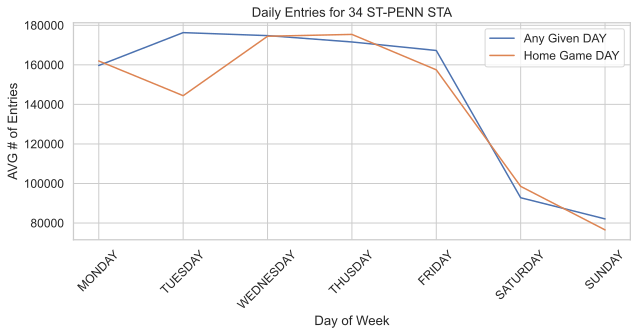

In [47]:
#plots the average daily entries of days with knicks home games for every day of the week (orange line) against days without knicks home games (blue line) for Penn station
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,PENN_STATION_SUM_not_nba,label="Any Given DAY")
plt.plot(daysofweek,PENN_STATION_SUM_nba,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34 ST-PENN STA')
plt.legend()

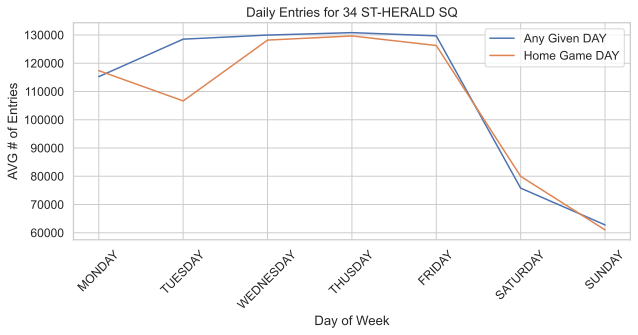

In [101]:
#plots the average daily entries of days with knicks home games for every day of the week (orange line) against days without knicks home games (blue line) for herald sq station
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,HERALD_STATION_SUM_not_nba,label="Any Given DAY")
plt.plot(daysofweek,HERALD_STATION_SUM_nba,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34 ST-HERALD SQ')
plt.legend()

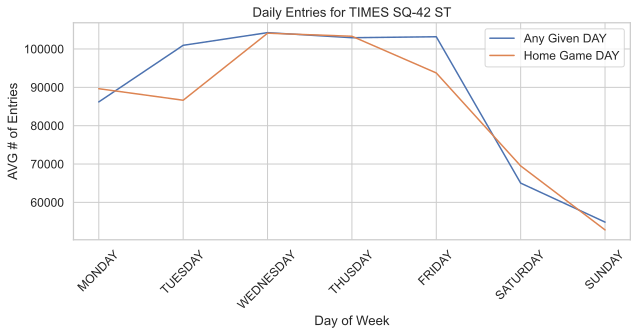

In [49]:
#plots the average daily entries of days with knicks home games for every day of the week (orange line) against days without knicks home games (blue line) for times sq station
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,TIMES_STATION_SUM_not_nba,label="Any Given DAY")
plt.plot(daysofweek,TIMES_STATION_SUM_nba,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for TIMES SQ-42 ST')
plt.legend()

**MVP METIS PROJECT 1**

For my exploratory data analysis of MTA traffic around Madison Square Garden (MSG), I gathered data on 3 stations (34 ST-HERALD SQ, 34 ST-PENN STA, TIMES SQ-42 ST) surrounding MSG. I cleaned the publicly accessible MTA data in order to get daily entries, and I also cleaned a dataframe for the knicks games schedule of the 2018-2019 season (obtained from basketball reference) such that it only contained their home games. I as able to join the tables and group by day of the week, then sum their daily entires and divide by counts of each day of the week in order to get an average daily entries on each day of the week (for the stations in question only). Additionally, was able to use various joins to get data on all the days within the 27 weeks of data I read that did not have a Knicks home game, and perform the same calculations on that data. The three graphs at the end of this jupyter notebook are the visual representation of this data. The orange lines are the days with knicks home games, and the blue lines are the days without knicks home games. The data iself reveals that my analysis was inconclusive as to the effect of knicks games on MTA traffic. I identify two possible sources of error as follows:

-The counts for the data were not large enough to generate a statistically significant result.

-The timeframe on which I joined my tables initially was not precise enough. joining on the 4 hour datatime intervals might be worth consideration.

In [50]:
##attempt to replicate above process on a 4 hour window

#Reread in nba dataframe
nba_games_data = pd.read_html('https://www.basketball-reference.com/teams/NYK/2019_games.html')[0]
nba_games_data.columns

Index(['G', 'Date', 'Start (ET)', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Opponent', 'Unnamed: 7', 'Unnamed: 8', 'Tm', 'Opp', 'W', 'L', 'Streak',
       'Notes'],
      dtype='object')

In [51]:
#cleaning nba dataframe for 4 hour time window (4:00 pm to 8:00 pm)
options = ['4:00p','4:30p','5:00p','5:30p','6:00p','6:30p','7:00p','7:30p','8:00p']
nba_games_data = nba_games_data.loc[nba_games_data['Start (ET)'].isin(options)] 
nba_games_data

,G,Date,Start (ET),Unnamed: 3,Unnamed: 4,Unnamed: 5,Opponent,Unnamed: 7,Unnamed: 8,Tm,Opp,W,L,Streak,Notes
0,1,"Wed, Oct 17, 2018",7:30p,NaN,Box Score,NaN,Atlanta Hawks,W,NaN,126,107,1,0,W 1,NaN
1,2,"Fri, Oct 19, 2018",7:30p,NaN,Box Score,@,Brooklyn Nets,L,NaN,105,107,1,1,L 1,NaN
2,3,"Sat, Oct 20, 2018",7:30p,NaN,Box Score,NaN,Boston Celtics,L,NaN,101,103,1,2,L 2,NaN
3,4,"Mon, Oct 22, 2018",8:00p,NaN,Box Score,@,Milwaukee Bucks,L,NaN,113,124,1,3,L 3,NaN
4,5,"Wed, Oct 24, 2018",7:30p,NaN,Box Score,@,Miami Heat,L,NaN,87,110,1,4,L 4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,78,"Wed, Apr 3, 2019",7:00p,NaN,Box Score,@,Orlando Magic,L,NaN,100,114,15,63,L 1,NaN
81,79,"Fri, Apr 5, 2019",8:00p,NaN,Box Score,@,Houston Rockets,L,NaN,96,120,15,64,L 2,NaN
82,80,"Sun, Apr 7, 2019",7:30p,NaN,Box Score,NaN,Washington Wizards,W,NaN,113,110,16,64,W 1,NaN
84,81,"Tue, Apr 9, 2019",8:00p,NaN,Box Score,@,Chicago Bulls,W,NaN,96,86,17,64,W 2,NaN


In [52]:
#cleaning nba data for home games only + inserting new column DATE_NEW
nba_games_data["DATE_NEW"] = pd.to_datetime(nba_games_data["Date"],format="%a, %b %d, %Y")
nba_games_data= nba_games_data[(nba_games_data['Unnamed: 5']!='@')][["DATE_NEW","Unnamed: 5"]]
nba_games_data

,DATE_NEW,Unnamed: 5
0,2018-10-17,NaN
2,2018-10-20,NaN
5,2018-10-26,NaN
6,2018-10-29,NaN
7,2018-10-31,NaN
10,2018-11-05,NaN
13,2018-11-11,NaN
17,2018-11-20,NaN
19,2018-11-23,NaN
24,2018-12-01,NaN


In [53]:
nba_games_data.shape

(34, 2)

In [54]:
turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
204710,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/12/2019,21:00:00,REGULAR,5554,374,2019-04-12 21:00:00
204709,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/12/2019,17:00:00,REGULAR,5554,374,2019-04-12 17:00:00
204708,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/12/2019,13:00:00,REGULAR,5554,374,2019-04-12 13:00:00
204707,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/12/2019,09:00:00,REGULAR,5554,374,2019-04-12 09:00:00
204706,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/12/2019,05:00:00,REGULAR,5554,374,2019-04-12 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/06/2018,16:00:00,REGULAR,6785161,2300468,2018-10-06 16:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/06/2018,12:00:00,REGULAR,6784900,2300425,2018-10-06 12:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/06/2018,08:00:00,REGULAR,6784806,2300335,2018-10-06 08:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/06/2018,04:00:00,REGULAR,6784789,2300296,2018-10-06 04:00:00


In [55]:
#checking data... hm?
mask_PENN1 = ((turnstiles_df["TIME"] == "16:00:00") &
        (turnstiles_df["STATION"] == "34 ST-PENN STA") &
        (turnstiles_df["DATE"] == "11/04/2018"))

turnstiles_df[mask_PENN1]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME


In [56]:
#DAYLIGHT SAVINGS SHIFT ---> this is why optionalpha includes "17:00:00" and "21:00:00"
mask_PENN2 = ((turnstiles_df["STATION"] == "34 ST-PENN STA") &
        (turnstiles_df["DATE"] == "11/04/2018"))

turnstiles_df[mask_PENN2]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
134648,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,11/04/2018,21:00:00,REGULAR,67750926,18097412,2018-11-04 21:00:00
134647,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,11/04/2018,17:00:00,REGULAR,67750801,18097099,2018-11-04 17:00:00
134646,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,11/04/2018,13:00:00,REGULAR,67750660,18096716,2018-11-04 13:00:00
134645,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,11/04/2018,09:00:00,REGULAR,67750523,18096420,2018-11-04 09:00:00
134644,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,11/04/2018,05:00:00,REGULAR,67750457,18096358,2018-11-04 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
52293,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,11/04/2018,15:00:00,REGULAR,2143563,2315129,2018-11-04 15:00:00
52292,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,11/04/2018,11:00:00,REGULAR,2143530,2314620,2018-11-04 11:00:00
52291,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,11/04/2018,07:00:00,REGULAR,2143509,2314299,2018-11-04 07:00:00
52290,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,11/04/2018,03:00:00,REGULAR,2143504,2314243,2018-11-04 03:00:00


In [57]:
#filtering dataframe for time window 4 pm to 8 pm
optionalpha= ["15:00:00","16:00:00","17:00:00","19:00:00","20:00:00","21:00:00"]
turnstiles_df = turnstiles_df.loc[turnstiles_df["TIME"].isin(optionalpha)]

In [58]:
#adding new columns and dropping null values
turnstiles_df["DATE_NEW"]= pd.to_datetime(turnstiles_df.DATE,format="%m/%d/%Y")
turnstiles_df[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_df[["DATE", "ENTRIES"]].shift(1))
turnstiles_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

<ipython-input-58-d73a82c95d5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df["DATE_NEW"]= pd.to_datetime(turnstiles_df.DATE,format="%m/%d/%Y")
/Users/carnevale10/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-58-d73a82c95d5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [59]:
#filtering for the correct rows to perform the subtraction of cumulative entries
turnstiles_df= turnstiles_df[(turnstiles_df['DATE']==turnstiles_df['PREV_DATE'])]

In [60]:
#cumulative entry subtraction: getting Daily entries
turnstiles_df["DAILY_ENTRIES"] = turnstiles_df.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 5214179 <-- 141.0
entries: 5454923 <-- 567.0
entries: 552542874 <-- 0.0
entries: 497147 <-- 552542874.0
entries: 1255443642 <-- 497147.0
entries: 27635837 <-- 1255443642.0
entries: 1988481 <-- 27635837.0
entries: 4661317 <-- 1988481.0
entries: 6212398 <-- 4661317.0
entries: 2295351 <-- 290287.0
entries: 4125278 <-- 292530.0
entries: 2899710 <-- 1350363.0
entries: 1910943 <-- 4050583.0
entries: 2302645 <-- 15198190.0
entries: 473529 <-- 6749425.0
entries: 2280214 <-- 2.0
entries: 44616569 <-- 1476232616.0
entries: 1357874 <-- 18324.0
entries: 12237 <-- 1357874.0
entries: 4355994 <-- 12237.0
entries: 484584 <-- 4355994.0
entries: 670366 <-- 10584925.0
entries: 5100005 <-- 1776599.0
entries: 3032108 <-- 8416088.0
entries: 5869852 <-- 2196639.0
entries: 2909492 <-- 459169.0
entries: 5490768 <-- 19.0
entries: 7673049 <-- 579.0
entries: 3846742 <-- 1319880.0
entries: 6437364 <-- 97.0
entries: 11323067 <-- 459313.0
entries: 14655214 <-- 5196016.0
entries: 10755609 <-- 67604768.0
entr

In [61]:
#filtering dataframe for first station: 34 ST-PENN STA
turnstiles_df1=turnstiles_df[turnstiles_df["STATION"]=="34 ST-PENN STA"]
turnstiles_df1

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DATE_NEW,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
134495,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/09/2019,17:00:00,REGULAR,67812299,18248107,2019-03-09 17:00:00,2019-03-09,03/09/2019,67812454.0,155.0
136663,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/08/2019,17:00:00,REGULAR,67811549,18247280,2019-03-08 17:00:00,2019-03-08,03/08/2019,67811785.0,236.0
136657,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/07/2019,17:00:00,REGULAR,67810841,18246014,2019-03-07 17:00:00,2019-03-07,03/07/2019,67811055.0,214.0
136651,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/06/2019,17:00:00,REGULAR,67810250,18244729,2019-03-06 17:00:00,2019-03-06,03/06/2019,67810427.0,177.0
136643,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,03/05/2019,17:00:00,REGULAR,67809628,18243459,2019-03-05 17:00:00,2019-03-05,03/05/2019,67809832.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51076,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,10/10/2018,16:00:00,REGULAR,2119347,2260739,2018-10-10 16:00:00,2018-10-10,10/10/2018,2119463.0,116.0
51070,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,10/09/2018,16:00:00,REGULAR,2118490,2258713,2018-10-09 16:00:00,2018-10-09,10/09/2018,2118603.0,113.0
51064,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,10/08/2018,16:00:00,REGULAR,2117536,2256998,2018-10-08 16:00:00,2018-10-08,10/08/2018,2117654.0,118.0
51058,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,10/07/2018,16:00:00,REGULAR,2116846,2255968,2018-10-07 16:00:00,2018-10-07,10/07/2018,2116963.0,117.0


In [62]:
#sorting dataframe and adding new columns to enumerate the day of week
station_daily_alpha = turnstiles_df1.groupby(["STATION", "DATE_NEW"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_alpha['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_alpha['DATE_NEW']).dt.dayofweek
station_daily_alpha.sort_values("DATE_NEW")

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM
0,34 ST-PENN STA,2018-10-06,23961.0,5
1,34 ST-PENN STA,2018-10-07,24627.0,6
2,34 ST-PENN STA,2018-10-08,30667.0,0
3,34 ST-PENN STA,2018-10-09,34975.0,1
4,34 ST-PENN STA,2018-10-10,35078.0,2
...,...,...,...,...
184,34 ST-PENN STA,2019-04-08,32806.0,0
185,34 ST-PENN STA,2019-04-09,35012.0,1
186,34 ST-PENN STA,2019-04-10,34407.0,2
187,34 ST-PENN STA,2019-04-11,34465.0,3


In [63]:
#merging data and sorting by DATE_NEW
merged_data_PENN_alpha1 = station_daily_alpha.merge(nba_games_data)
merged_data_PENN_alpha1.sort_values("DATE_NEW")

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM,Unnamed: 5
0,34 ST-PENN STA,2018-10-17,35456.0,2,NaN
1,34 ST-PENN STA,2018-10-20,18809.0,5,NaN
2,34 ST-PENN STA,2018-10-26,35342.0,4,NaN
3,34 ST-PENN STA,2018-10-29,33791.0,0,NaN
4,34 ST-PENN STA,2018-10-31,24915.0,2,NaN
5,34 ST-PENN STA,2018-11-05,45576.0,0,NaN
6,34 ST-PENN STA,2018-11-11,25824.0,6,NaN
7,34 ST-PENN STA,2018-11-20,45948.0,1,NaN
8,34 ST-PENN STA,2018-11-23,32971.0,4,NaN
9,34 ST-PENN STA,2018-12-01,30399.0,5,NaN


In [64]:
merged_data_PENN_alpha1.shape

(34, 5)

In [65]:
#summing daily entries for each day of the week
sum_entries_nba_alpha = merged_data_PENN_alpha1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba_alpha

DAY_OF_WEEK_NUM
0    203197.0
1    132314.0
2    256534.0
3     78476.0
4    269945.0
5    123051.0
6    108724.0
Name: DAILY_ENTRIES, dtype: float64

In [66]:
#summing counts for each day of the week
sum_counts_nba_alpha = merged_data_PENN_alpha1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba_alpha

0    5
1    3
2    7
3    2
4    7
5    5
6    5
Name: DAY_OF_WEEK_NUM, dtype: int64

In [67]:
#computing average daily entries for each day of the week
PENN_STATION_SUM_nba_alpha = sum_entries_nba_alpha/sum_counts_nba_alpha
PENN_STATION_SUM_nba_alpha

DAY_OF_WEEK_NUM
0    40639.400000
1    44104.666667
2    36647.714286
3    39238.000000
4    38563.571429
5    24610.200000
6    21744.800000
dtype: float64

In [68]:
#merging data to get all entries that are not linked to knicks home games + getting rid of outliers
merged_data_PENN_alpha2 = pd.merge(station_daily_alpha, merged_data_PENN_alpha1,indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
merged_data_PENN_alpha2=merged_data_PENN_alpha2[merged_data_PENN_alpha2.DAILY_ENTRIES<100000.0]
merged_data_PENN_alpha2=merged_data_PENN_alpha2[merged_data_PENN_alpha2.DAILY_ENTRIES>5000.0]
merged_data_PENN_alpha2

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM,Unnamed: 5
0,34 ST-PENN STA,2018-10-06,23961.0,5,NaN
1,34 ST-PENN STA,2018-10-07,24627.0,6,NaN
2,34 ST-PENN STA,2018-10-08,30667.0,0,NaN
3,34 ST-PENN STA,2018-10-09,34975.0,1,NaN
4,34 ST-PENN STA,2018-10-10,35078.0,2,NaN
...,...,...,...,...,...
182,34 ST-PENN STA,2019-04-06,17988.0,5,NaN
184,34 ST-PENN STA,2019-04-08,32806.0,0,NaN
185,34 ST-PENN STA,2019-04-09,35012.0,1,NaN
187,34 ST-PENN STA,2019-04-11,34465.0,3,NaN


In [69]:
#summing daily entries for each day of the week
sum_entries_not_nba_alpha2 = merged_data_PENN_alpha2.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba_alpha2

DAY_OF_WEEK_NUM
0    802472.0
1    919723.0
2    789626.0
3    996418.0
4    792194.0
5    511812.0
6    456057.0
Name: DAILY_ENTRIES, dtype: float64

In [70]:
#summing counts for each day of the week
sum_counts_not_nba_alpha2 = merged_data_PENN_alpha2.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba_alpha2

0    22
1    24
2    19
3    25
4    20
5    22
6    21
Name: DAY_OF_WEEK_NUM, dtype: int64

In [71]:
#computing average daily entries for each day of the week
PENN_STATION_SUM_not_nba_alpha2 = sum_entries_not_nba_alpha2/sum_counts_not_nba_alpha2
PENN_STATION_SUM_not_nba_alpha2

DAY_OF_WEEK_NUM
0    36476.000000
1    38321.791667
2    41559.263158
3    39856.720000
4    39609.700000
5    23264.181818
6    21717.000000
dtype: float64

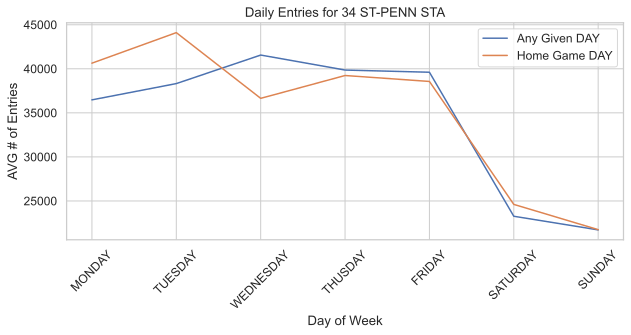

In [72]:
#plotting data
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,PENN_STATION_SUM_not_nba_alpha2,label="Any Given DAY")
plt.plot(daysofweek,PENN_STATION_SUM_nba_alpha,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34 ST-PENN STA')
plt.legend()

In [73]:
#data was shifted back 1 hour instead of ahead ---> optionalpha expanded to include "15:00:00" and "19:00:00"
mask_HERALD1 = ((turnstiles_df["STATION"] == "34 ST-HERALD SQ") &
        (turnstiles_df["DATE"] == "03/09/2019"))

turnstiles_df[mask_HERALD1]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DATE_NEW,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
96625,N507,R023,00-03-06,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,4246978,149261,2019-03-09 15:00:00,2019-03-09,03/09/2019,4.247744e+06,766.0
96580,N507,R023,00-03-05,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,24893147,1744599,2019-03-09 15:00:00,2019-03-09,03/09/2019,2.489380e+07,657.0
96535,N507,R023,00-03-04,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,2311207,471110,2019-03-09 15:00:00,2019-03-09,03/09/2019,2.311785e+06,578.0
96490,N507,R023,00-03-03,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,1683414,606501,2019-03-09 15:00:00,2019-03-09,03/09/2019,1.683724e+06,310.0
96445,N507,R023,00-03-02,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,4132142,3000035,2019-03-09 15:00:00,2019-03-09,03/09/2019,4.132364e+06,222.0
96400,N507,R023,00-03-01,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,2904186,3795003,2019-03-09 15:00:00,2019-03-09,03/09/2019,2.904323e+06,137.0
96355,N507,R023,00-03-00,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,495414,4792645,2019-03-09 15:00:00,2019-03-09,03/09/2019,4.954190e+05,5.0
96310,N507,R023,00-00-03,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,30167,128871,2019-03-09 15:00:00,2019-03-09,03/09/2019,3.021100e+04,44.0
96265,N507,R023,00-00-02,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,1911964,21168914,2019-03-09 15:00:00,2019-03-09,03/09/2019,1.911988e+06,24.0
96220,N507,R023,00-00-01,34 ST-HERALD SQ,BDFMNQRW,IND,03/09/2019,15:00:00,REGULAR,2303170,8044180,2019-03-09 15:00:00,2019-03-09,03/09/2019,2.303189e+06,19.0


In [74]:
#Station 2: 34 ST-HERALD SQ
turnstiles_df2=turnstiles_df[turnstiles_df["STATION"]=="34 ST-HERALD SQ"]
turnstiles_df2

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DATE_NEW,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
98754,N507,R023,00-06-00,34 ST-HERALD SQ,BDFMNQRW,IND,03/05/2019,19:00:00,REGULAR,552542874,552542447,2019-03-05 19:00:00,2019-03-05,03/05/2019,0.000000e+00,0.0
98753,N507,R023,00-05-05,34 ST-HERALD SQ,BDFMNQRW,IND,03/05/2019,19:00:00,REGULAR,497147,339744,2019-03-05 19:00:00,2019-03-05,03/05/2019,5.525429e+08,497147.0
98752,N507,R023,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,03/05/2019,19:00:00,REGULAR,1255443642,2048188732,2019-03-05 19:00:00,2019-03-05,03/05/2019,4.971470e+05,497147.0
98751,N507,R023,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,03/05/2019,19:00:00,REGULAR,27635837,12167986,2019-03-05 19:00:00,2019-03-05,03/05/2019,1.255444e+09,0.0
98750,N507,R023,00-05-02,34 ST-HERALD SQ,BDFMNQRW,IND,03/05/2019,19:00:00,REGULAR,1988481,653200,2019-03-05 19:00:00,2019-03-05,03/05/2019,2.763584e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,10/10/2018,16:00:00,REGULAR,25916623,10638822,2018-10-10 16:00:00,2018-10-10,10/10/2018,2.591924e+07,2615.0
2985,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,10/09/2018,16:00:00,REGULAR,25910821,10635991,2018-10-09 16:00:00,2018-10-09,10/09/2018,2.591343e+07,2612.0
2979,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,10/08/2018,16:00:00,REGULAR,25905672,10633361,2018-10-08 16:00:00,2018-10-08,10/08/2018,2.590790e+07,2230.0
2973,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,10/07/2018,16:00:00,REGULAR,25901721,10630832,2018-10-07 16:00:00,2018-10-07,10/07/2018,2.590295e+07,1231.0


In [75]:
#sorting dataframe and adding new columns to enumerate the day of week
station_daily_beta = turnstiles_df2.groupby(["STATION", "DATE_NEW"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_beta['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_beta['DATE_NEW']).dt.dayofweek
station_daily_beta.sort_values("DATE_NEW")

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM
0,34 ST-HERALD SQ,2018-10-06,26809.0,5
1,34 ST-HERALD SQ,2018-10-07,24892.0,6
2,34 ST-HERALD SQ,2018-10-08,50426.0,0
3,34 ST-HERALD SQ,2018-10-09,57366.0,1
4,34 ST-HERALD SQ,2018-10-10,55944.0,2
...,...,...,...,...
184,34 ST-HERALD SQ,2019-04-08,51376.0,0
185,34 ST-HERALD SQ,2019-04-09,52976.0,1
186,34 ST-HERALD SQ,2019-04-10,53279.0,2
187,34 ST-HERALD SQ,2019-04-11,52466.0,3


In [76]:
#merging data and sorting by DATE_NEW
merged_data_HERALD_beta1 = station_daily_beta.merge(nba_games_data)
merged_data_HERALD_beta1.sort_values("DATE_NEW")

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM,Unnamed: 5
0,34 ST-HERALD SQ,2018-10-17,57431.0,2,NaN
1,34 ST-HERALD SQ,2018-10-20,25002.0,5,NaN
2,34 ST-HERALD SQ,2018-10-26,56033.0,4,NaN
3,34 ST-HERALD SQ,2018-10-29,54707.0,0,NaN
4,34 ST-HERALD SQ,2018-10-31,54976.0,2,NaN
5,34 ST-HERALD SQ,2018-11-05,52732.0,0,NaN
6,34 ST-HERALD SQ,2018-11-11,23020.0,6,NaN
7,34 ST-HERALD SQ,2018-11-20,53022.0,1,NaN
8,34 ST-HERALD SQ,2018-11-23,43086.0,4,NaN
9,34 ST-HERALD SQ,2018-12-01,28176.0,5,NaN


In [77]:
merged_data_HERALD_beta1.shape

(34, 5)

In [78]:
#summing daily entries for each day of the week
sum_entries_nba_beta = merged_data_HERALD_beta1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba_beta

DAY_OF_WEEK_NUM
0    266940.0
1    150572.0
2    366380.0
3    101559.0
4    343234.0
5    132506.0
6    104491.0
Name: DAILY_ENTRIES, dtype: float64

In [79]:
#summing counts for each day of the week
sum_counts_nba_beta = merged_data_HERALD_beta1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba_beta

0    5
1    3
2    7
3    2
4    7
5    5
6    5
Name: DAY_OF_WEEK_NUM, dtype: int64

In [80]:
#computing average daily entries for each day of the week
HERALD_STATION_SUM_nba_beta = sum_entries_nba_beta/sum_counts_nba_beta
HERALD_STATION_SUM_nba_beta

DAY_OF_WEEK_NUM
0    53388.000000
1    50190.666667
2    52340.000000
3    50779.500000
4    49033.428571
5    26501.200000
6    20898.200000
dtype: float64

In [81]:
#merging data to get all entries that are not linked to knicks home games + getting rid of outliers
merged_data_HERALD_beta2 = pd.merge(station_daily_beta, merged_data_HERALD_beta1,indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
merged_data_HERALD_beta2 = merged_data_HERALD_beta2[merged_data_HERALD_beta2.DAILY_ENTRIES<100000.0]
merged_data_HERALD_beta2 = merged_data_HERALD_beta2[merged_data_HERALD_beta2.DAILY_ENTRIES>5000.0]
merged_data_HERALD_beta2

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM,Unnamed: 5
0,34 ST-HERALD SQ,2018-10-06,26809.0,5,NaN
1,34 ST-HERALD SQ,2018-10-07,24892.0,6,NaN
2,34 ST-HERALD SQ,2018-10-08,50426.0,0,NaN
3,34 ST-HERALD SQ,2018-10-09,57366.0,1,NaN
4,34 ST-HERALD SQ,2018-10-10,55944.0,2,NaN
...,...,...,...,...,...
182,34 ST-HERALD SQ,2019-04-06,26467.0,5,NaN
184,34 ST-HERALD SQ,2019-04-08,51376.0,0,NaN
185,34 ST-HERALD SQ,2019-04-09,52976.0,1,NaN
187,34 ST-HERALD SQ,2019-04-11,52466.0,3,NaN


In [82]:
#summing daily entries for each day of the week
sum_entries_not_nba_beta2 = merged_data_HERALD_beta2.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba_beta2

DAY_OF_WEEK_NUM
0    1041265.0
1    1138092.0
2    1041228.0
3    1265726.0
4    1023621.0
5     567015.0
6     471827.0
Name: DAILY_ENTRIES, dtype: float64

In [83]:
#summing counts for each day of the week
sum_counts_not_nba_beta2 = merged_data_HERALD_beta2.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba_beta2

0    22
1    23
2    20
3    25
4    20
5    22
6    22
Name: DAY_OF_WEEK_NUM, dtype: int64

In [84]:
#computing average daily entries for each day of the week
HERALD_STATION_SUM_not_nba_beta2 = sum_entries_not_nba_beta2/sum_counts_not_nba_beta2
HERALD_STATION_SUM_not_nba_beta2

DAY_OF_WEEK_NUM
0    47330.227273
1    49482.260870
2    52061.400000
3    50629.040000
4    51181.050000
5    25773.409091
6    21446.681818
dtype: float64

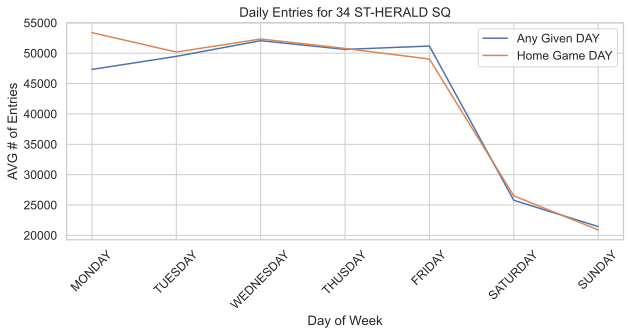

In [85]:
#plotting data
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,HERALD_STATION_SUM_not_nba_beta2,label="Any Given DAY")
plt.plot(daysofweek,HERALD_STATION_SUM_nba_beta,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34 ST-HERALD SQ')
plt.legend()

In [86]:
#data was shifted back 1 hour instead of ahead ---> optionalpha expanded to include "15:00:00" and "19:00:00"
mask_TIMES1 = ((turnstiles_df["STATION"] == "TIMES SQ-42 ST") &
        (turnstiles_df["DATE"] == "03/09/2019"))

turnstiles_df[mask_TIMES1]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DATE_NEW,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
136232,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,7736713,2490708,2019-03-09 15:00:00,2019-03-09,03/09/2019,7.737512e+06,799.0
136190,R151,R033,00-00-07,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,723586,479101,2019-03-09 15:00:00,2019-03-09,03/09/2019,7.242950e+05,709.0
136148,R151,R033,00-00-06,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,7963573,9716011,2019-03-09 15:00:00,2019-03-09,03/09/2019,7.964324e+06,751.0
136106,R151,R033,00-00-05,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,36809108,89013101,2019-03-09 15:00:00,2019-03-09,03/09/2019,3.680980e+07,690.0
136064,R151,R033,00-00-04,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,16236896,24918243,2019-03-09 15:00:00,2019-03-09,03/09/2019,1.623766e+07,762.0
136022,R151,R033,00-00-03,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,6766570,9538780,2019-03-09 15:00:00,2019-03-09,03/09/2019,6.767355e+06,785.0
135980,R151,R033,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,10037096,7947190,2019-03-09 15:00:00,2019-03-09,03/09/2019,1.003800e+07,905.0
135938,R151,R033,00-00-01,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,1718349453,320222886,2019-03-09 15:00:00,2019-03-09,03/09/2019,1.718351e+09,1280.0
135896,R151,R033,00-00-00,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,1454240,3785690,2019-03-09 15:00:00,2019-03-09,03/09/2019,1.454268e+06,28.0
135855,R148,R033,01-06-01,TIMES SQ-42 ST,1237ACENQRSW,IRT,03/09/2019,15:00:00,REGULAR,68629735,17360735,2019-03-09 15:00:00,2019-03-09,03/09/2019,6.863041e+07,676.0


In [87]:
#Station 3: TIMES SQ-42 ST
turnstiles_df3=turnstiles_df[turnstiles_df["STATION"]=="TIMES SQ-42 ST"]
turnstiles_df3

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DATE_NEW,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
138899,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,04/12/2019,16:00:00,REGULAR,7851298,2523501,2019-04-12 16:00:00,2019-04-12,04/12/2019,7852356.0,1058.0
138892,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,04/11/2019,16:00:00,REGULAR,7847545,2522495,2019-04-11 16:00:00,2019-04-11,04/11/2019,7848540.0,995.0
138886,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,04/10/2019,16:00:00,REGULAR,7843861,2521580,2019-04-10 16:00:00,2019-04-10,04/10/2019,7844854.0,993.0
138879,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,04/09/2019,16:00:00,REGULAR,7840000,2520595,2019-04-09 16:00:00,2019-04-09,04/09/2019,7841116.0,1116.0
138873,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,04/08/2019,16:00:00,REGULAR,7836394,2519640,2019-04-08 16:00:00,2019-04-08,04/08/2019,7837387.0,993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,10/10/2018,16:00:00,REGULAR,8213060,9966623,2018-10-10 16:00:00,2018-10-10,10/10/2018,8214633.0,1573.0
2611,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,10/09/2018,16:00:00,REGULAR,8209144,9961352,2018-10-09 16:00:00,2018-10-09,10/09/2018,8210759.0,1615.0
2603,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,10/08/2018,16:00:00,REGULAR,8205591,9956435,2018-10-08 16:00:00,2018-10-08,10/08/2018,8206960.0,1369.0
2597,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,10/07/2018,16:00:00,REGULAR,8203667,9952513,2018-10-07 16:00:00,2018-10-07,10/07/2018,8204076.0,409.0


In [88]:
#sorting dataframe and adding new columns to enumerate the day of week
station_daily_gamma = turnstiles_df3.groupby(["STATION", "DATE_NEW"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_gamma['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_gamma['DATE_NEW']).dt.dayofweek
station_daily_gamma.sort_values("DATE_NEW")

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM
0,TIMES SQ-42 ST,2018-10-06,22125.0,5
1,TIMES SQ-42 ST,2018-10-07,20073.0,6
2,TIMES SQ-42 ST,2018-10-08,37961.0,0
3,TIMES SQ-42 ST,2018-10-09,45388.0,1
4,TIMES SQ-42 ST,2018-10-10,46645.0,2
...,...,...,...,...
184,TIMES SQ-42 ST,2019-04-08,43347.0,0
185,TIMES SQ-42 ST,2019-04-09,46603.0,1
186,TIMES SQ-42 ST,2019-04-10,45726.0,2
187,TIMES SQ-42 ST,2019-04-11,43273.0,3


In [102]:
#merging data and sorting by DATE_NEW
merged_data_TIMES_gamma1 = station_daily_gamma.merge(nba_games_data)
merged_data_TIMES_gamma1.sort_values("DATE_NEW")

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM,Unnamed: 5
0,TIMES SQ-42 ST,2018-10-17,47647.0,2,NaN
1,TIMES SQ-42 ST,2018-10-20,19994.0,5,NaN
2,TIMES SQ-42 ST,2018-10-26,44220.0,4,NaN
3,TIMES SQ-42 ST,2018-10-29,46027.0,0,NaN
4,TIMES SQ-42 ST,2018-10-31,46941.0,2,NaN
5,TIMES SQ-42 ST,2018-11-05,43923.0,0,NaN
6,TIMES SQ-42 ST,2018-11-11,18389.0,6,NaN
7,TIMES SQ-42 ST,2018-11-20,42196.0,1,NaN
8,TIMES SQ-42 ST,2018-11-23,22766.0,4,NaN
9,TIMES SQ-42 ST,2018-12-01,25058.0,5,NaN


In [103]:
merged_data_TIMES_gamma1.shape

(34, 5)

In [104]:
#summing daily entries for each day of the week
sum_entries_nba_gamma = merged_data_TIMES_gamma1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba_gamma

DAY_OF_WEEK_NUM
0    219811.0
1    123647.0
2    312967.0
3     84288.0
4    263661.0
5    107645.0
6     83935.0
Name: DAILY_ENTRIES, dtype: float64

In [105]:
#summing counts for each day of the week
sum_counts_nba_gamma = merged_data_TIMES_gamma1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba_gamma

0    5
1    3
2    7
3    2
4    7
5    5
6    5
Name: DAY_OF_WEEK_NUM, dtype: int64

In [106]:
#computing average daily entries for each day of the week
TIMES_STATION_SUM_nba_gamma = sum_entries_nba_gamma/sum_counts_nba_gamma
TIMES_STATION_SUM_nba_gamma

DAY_OF_WEEK_NUM
0    43962.200000
1    41215.666667
2    44709.571429
3    42144.000000
4    37665.857143
5    21529.000000
6    16787.000000
dtype: float64

In [107]:
#merging data to get all entries that are not linked to knicks home games + getting rid of outliers
merged_data_TIMES_gamma2 = pd.merge(station_daily_gamma, merged_data_TIMES_gamma1,indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
merged_data_TIMES_gamma2 = merged_data_TIMES_gamma2[merged_data_TIMES_gamma2.DAILY_ENTRIES<100000.0]
merged_data_TIMES_gamma2 = merged_data_TIMES_gamma2[merged_data_TIMES_gamma2.DAILY_ENTRIES>5000.0]
merged_data_TIMES_gamma2

,STATION,DATE_NEW,DAILY_ENTRIES,DAY_OF_WEEK_NUM,Unnamed: 5
0,TIMES SQ-42 ST,2018-10-06,22125.0,5,NaN
1,TIMES SQ-42 ST,2018-10-07,20073.0,6,NaN
2,TIMES SQ-42 ST,2018-10-08,37961.0,0,NaN
3,TIMES SQ-42 ST,2018-10-09,45388.0,1,NaN
4,TIMES SQ-42 ST,2018-10-10,46645.0,2,NaN
...,...,...,...,...,...
182,TIMES SQ-42 ST,2019-04-06,21629.0,5,NaN
184,TIMES SQ-42 ST,2019-04-08,43347.0,0,NaN
185,TIMES SQ-42 ST,2019-04-09,46603.0,1,NaN
187,TIMES SQ-42 ST,2019-04-11,43273.0,3,NaN


In [95]:
#summing daily entries for each day of the week
sum_entries_not_nba_gamma2 = merged_data_TIMES_gamma2.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba_gamma2

DAY_OF_WEEK_NUM
0     805558.0
1     986700.0
2     860562.0
3    1045339.0
4     824060.0
5     445808.0
6     371881.0
Name: DAILY_ENTRIES, dtype: float64

In [96]:
#summing counts for each day of the week
sum_counts_not_nba_gamma2 = merged_data_TIMES_gamma2.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba_gamma2

0    21
1    24
2    20
3    25
4    20
5    22
6    22
Name: DAY_OF_WEEK_NUM, dtype: int64

In [97]:
#computing average daily entries for each day of the week
TIMES_STATION_SUM_not_nba_gamma2 = sum_entries_not_nba_gamma2/sum_counts_not_nba_gamma2
TIMES_STATION_SUM_not_nba_gamma2

DAY_OF_WEEK_NUM
0    38359.904762
1    41112.500000
2    43028.100000
3    41813.560000
4    41203.000000
5    20264.000000
6    16903.681818
dtype: float64

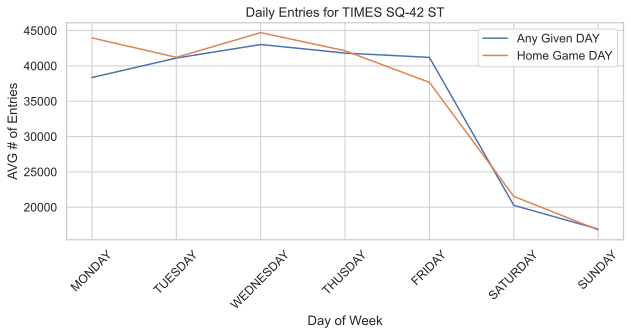

In [98]:
#plotting data
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,TIMES_STATION_SUM_not_nba_gamma2,label="Any Given DAY")
plt.plot(daysofweek,TIMES_STATION_SUM_nba_gamma,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for TIMES SQ-42 ST')
plt.legend()

**METIS PROJECT 1 PART 2**

After further analysis of the data, no new conclusions can be drawn. It appears that the same calculation with a narrower window of recorded entries could be done for all three stations, though adjustments on the time stamps (between 11/04/2018 and 03/09/2019) due to daylight savings had to be accounted for. 

I was not able to address the lack of sufficient counts for each day the the week average computed on daily entries. Doing so would require analysis over multiple years/NBA seasons with potential adjustments for inflation in MTA usage across years. 
